# Google Stock Prediction
---

In [1]:
%matplotlib notebook
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, Flatten, BatchNormalization, LeakyReLU, Input, Dropout, Dense, Add, Dropout, LSTM
from tensorflow.keras import Model, datasets, models
from tensorflow.keras.optimizers import Adam
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## EDA

1. Load the dataset using Pandas.
2. Observe a few rows of the dataset carefully.
3. Check for a number of feature columns present in it.
4. Use info() to check datatypes of all feature columns it also shows various info about the dataset.
5. Check for, if null values present in the dataset. 
6. Use describe() to check various statistical information about data.

In [2]:
# Read and view the file

data = pd.read_csv('GOOG.csv', date_parser=True)

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
1,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
3,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
4,2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401
...,...,...,...,...,...,...,...
4801,2023-09-18,137.630005,139.929993,137.630005,138.960007,138.960007,16233600
4802,2023-09-19,138.250000,139.175003,137.500000,138.830002,138.830002,15479100
4803,2023-09-20,138.830002,138.839996,134.520004,134.589996,134.589996,21473500
4804,2023-09-21,132.389999,133.190002,131.089996,131.360001,131.360001,22042700


In [3]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4806.000000,4806.000000,4806.000000,4806.000000,4806.000000,4.806000e+03
mean,40.499572,40.929610,40.086458,40.514541,40.514541,1.197895e+08
std,37.580158,38.013138,37.188927,37.602949,37.602949,1.513049e+08
min,2.470490,2.534002,2.464263,2.490913,2.490913,1.584340e+05
25%,12.783459,12.921815,12.675801,12.802700,12.802700,2.895195e+07
50%,26.372056,26.572545,26.152586,26.360721,26.360721,6.340678e+07
75%,56.564752,57.199126,55.918750,56.665125,56.665125,1.477507e+08
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.650833e+09


In [4]:
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

<IPython.core.display.Javascript object>


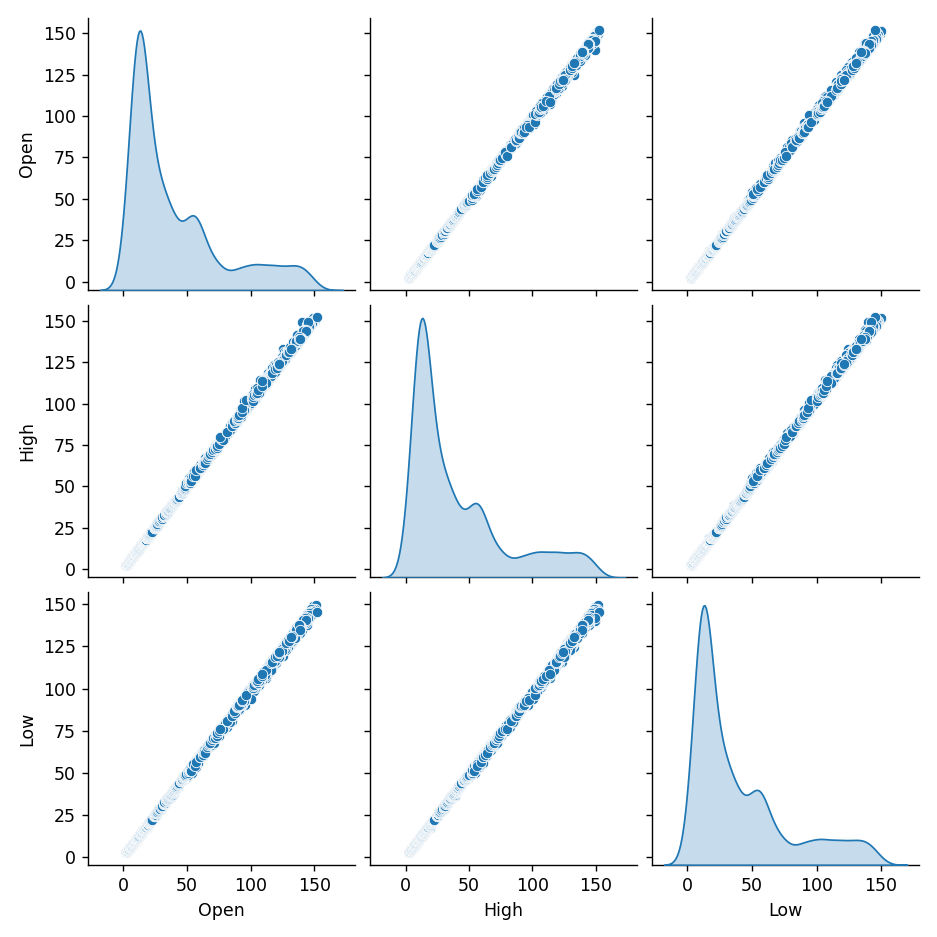

In [5]:
sns.pairplot(data[['Open','High','Low']], diag_kind='kde')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4806 entries, 0 to 4805
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4806 non-null   object 
 1   Open       4806 non-null   float64
 2   High       4806 non-null   float64
 3   Low        4806 non-null   float64
 4   Close      4806 non-null   float64
 5   Adj Close  4806 non-null   float64
 6   Volume     4806 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 263.0+ KB


# Feature Engineering

1. Make the Date column as pandas DATETIME datatype.
2. Create day, month and year as 3 new features from the Date column.
3. For training data we will take data before 2019-01-01.
4. For testing data we will take data on and after 2019-01-01.
5. Delete the Date column as we no longer need it.
6. Do Feature normalization using MinMaxScaler()
7. x_train should contain the previous 60 samples with all features.  
8. y_train should contain the 61st sample of 'Open' value as we are predicting the stock's High price for the next day.

In [26]:
# Converting date column to pandas DATETIME datatype

data['Date'] = pd.to_datetime(data['Date'])

In [27]:
# Create day, month and year as 3 new features form Date column.

data['Day'] = data['Date'].dt.day

data['Month'] = data['Date'].dt.month

data['Year'] = data['Date'].dt.year  

In [28]:
# For training data we will take data before 2019-01-01

train_data = data[data['Date']< '2023-01-01'].copy()

train_data

,Date,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year
0,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488,20,8,2004
1,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939,23,8,2004
2,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159,24,8,2004
3,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512,25,8,2004
4,2004-08-26,2.613952,2.688672,2.606729,2.687676,2.687676,142572401,26,8,2004
...,...,...,...,...,...,...,...,...,...,...
4619,2022-12-23,87.620003,90.099998,87.620003,89.809998,89.809998,17815000,23,12,2022
4620,2022-12-27,89.309998,89.500000,87.535004,87.930000,87.930000,15470900,27,12,2022
4621,2022-12-28,87.500000,88.519997,86.370003,86.459999,86.459999,17879600,28,12,2022
4622,2022-12-29,87.029999,89.364998,86.989998,88.949997,88.949997,18280700,29,12,2022


In [10]:
# For testing data we will take data on and after 2019-01-01

test_data = data[data['Date']>='2023-01-01'].copy()

test_data

,Date,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year
4624,2023-01-03,89.830002,91.550003,89.019997,89.699997,89.699997,20738500,3,1,2023
4625,2023-01-04,91.010002,91.239998,87.800003,88.709999,88.709999,27046500,4,1,2023
4626,2023-01-05,88.070000,88.209999,86.559998,86.769997,86.769997,23136100,5,1,2023
4627,2023-01-06,87.360001,88.470001,85.570000,88.160004,88.160004,26612600,6,1,2023
4628,2023-01-09,89.195000,90.830002,88.580002,88.800003,88.800003,22996700,9,1,2023
...,...,...,...,...,...,...,...,...,...,...
4801,2023-09-18,137.630005,139.929993,137.630005,138.960007,138.960007,16233600,18,9,2023
4802,2023-09-19,138.250000,139.175003,137.500000,138.830002,138.830002,15479100,19,9,2023
4803,2023-09-20,138.830002,138.839996,134.520004,134.589996,134.589996,21473500,20,9,2023
4804,2023-09-21,132.389999,133.190002,131.089996,131.360001,131.360001,22042700,21,9,2023


In [11]:
# we will delete Date column

x_data = train_data.drop(['Date'], axis=1)

x_data

,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year
0,2.515820,2.716817,2.503118,2.697639,2.697639,458857488,20,8,2004
1,2.758411,2.826406,2.716070,2.724787,2.724787,366857939,23,8,2004
2,2.770615,2.779581,2.579581,2.611960,2.611960,306396159,24,8,2004
3,2.614201,2.689918,2.587302,2.640104,2.640104,184645512,25,8,2004
4,2.613952,2.688672,2.606729,2.687676,2.687676,142572401,26,8,2004
...,...,...,...,...,...,...,...,...,...
4619,87.620003,90.099998,87.620003,89.809998,89.809998,17815000,23,12,2022
4620,89.309998,89.500000,87.535004,87.930000,87.930000,15470900,27,12,2022
4621,87.500000,88.519997,86.370003,86.459999,86.459999,17879600,28,12,2022
4622,87.029999,89.364998,86.989998,88.949997,88.949997,18280700,29,12,2022


In [12]:
# Feature normalization using MinMaxScaler()

scaler = MinMaxScaler()

x_data = scaler.fit_transform(x_data)

x_data.shape

(4624, 9)

In [13]:
x_train = []
y_train = []

# We will feed 60 samples and 61st is predicted from High column.

# In this manner we will learn LSTM network to predict based on last 60 samples

for i in range(60, x_data.shape[0]):
    x_train.append(x_data[i-60:i])
    y_train.append(x_data[i,1])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [14]:
x_train.shape

(4564, 60, 9)

In [15]:
y_train.shape

(4564,)

In [16]:
# Create LSTM model

def stock():
    
    I = Input(shape=[x_train.shape[1],9])
    
    L1 = LSTM(units=50, activation='relu', return_sequences=True)(I)
    D1 = Dropout(0.2)(L1)
    
    L2 = LSTM(units=60, activation='relu', return_sequences=True)(D1)
    D2 = Dropout(0.2)(L2)
    
    L3 = LSTM(units=70, activation='relu', return_sequences=True)(D2)
    D3 = Dropout(0.2)(L3)
    
    L4 = LSTM(units=100, activation='relu')(D3)
    D4 = Dropout(0.2)(L4)
    
    out = Dense(1)(D4)
    
    model = Model(inputs=I, outputs=out)
    
    return model

In [17]:
model = stock()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 9)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 50)            12000     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 70)            36680     
                                                                 
 dropout_2 (Dropout)         (None, 60, 70)            0     

In [18]:
# Compile and fit the model

epochs = 10

model.compile(optimizer='adam', loss='MSE')

keras = model.fit(x_train, y_train, batch_size=100, epochs=epochs, validation_split=0.2)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
37/37 [==============================] - ETA: 0s - loss: 0.0058WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000018B04309708> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full

<IPython.core.display.Javascript object>


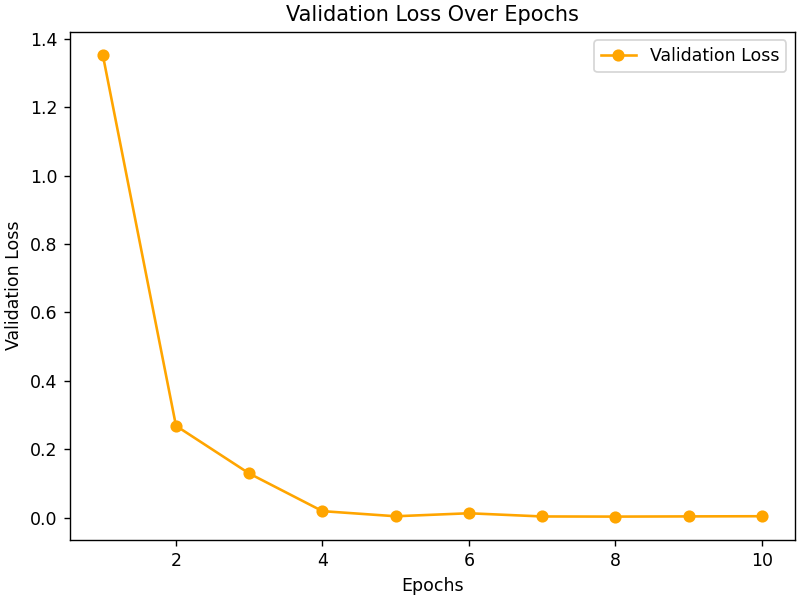

In [19]:
# Plot Validation Loss

validation_loss = keras.history['val_loss']

plt.figure(constrained_layout=True)
xval = range(1, epochs + 1)
plt.plot(xval, validation_loss, label='Validation Loss', marker='o', linestyle='-', color='orange')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
#plt.grid(True)
plt.savefig('Vloss.png')
plt.show()

<IPython.core.display.Javascript object>


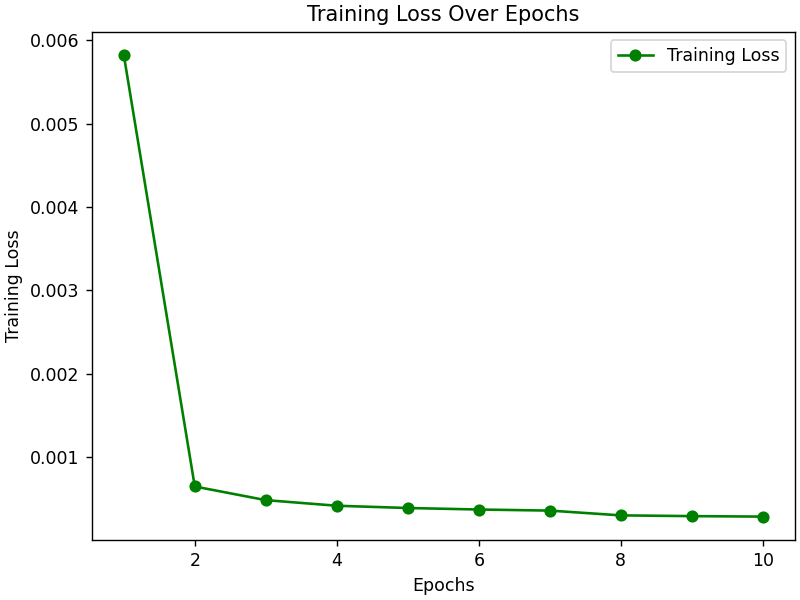

In [20]:
# Plot Training Loss

training_loss = keras.history['loss']

plt.figure(constrained_layout=True)
plt.plot(xval, training_loss, label='Training Loss', marker='o', linestyle='-', color='green')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
#plt.grid(True)
plt.savefig('Tloss.png')
plt.show()

In [21]:
# Taking last 60 samples from training data and adding to test data as per prediction model requirment. 

last_60 = train_data.tail(60)

xtest = last_60.append(test_data, ignore_index=True)

xtest = xtest.drop(['Date'], axis=1)

xtest

,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year
0,101.500000,103.730003,101.500000,102.239998,102.239998,17156200,6,10,2022
1,100.650002,101.419998,99.209999,99.570000,99.570000,24249900,7,10,2022
2,99.849998,99.989998,97.870003,98.709999,98.709999,16529900,10,10,2022
3,98.250000,100.120003,97.250000,98.050003,98.050003,21617700,11,10,2022
4,98.269997,99.648003,97.669998,98.300003,98.300003,17343400,12,10,2022
...,...,...,...,...,...,...,...,...,...
237,137.630005,139.929993,137.630005,138.960007,138.960007,16233600,18,9,2023
238,138.250000,139.175003,137.500000,138.830002,138.830002,15479100,19,9,2023
239,138.830002,138.839996,134.520004,134.589996,134.589996,21473500,20,9,2023
240,132.389999,133.190002,131.089996,131.360001,131.360001,22042700,21,9,2023


In [22]:
# Feature Scaling for test data using MinMaxScaler()

xt = scaler.transform(xtest)


x_test = []
y_test = []

for i in range(60,xt.shape[0]):
    x_test.append(xt[i-60:i])
    y_test.append(xt[i,1])

x_test = np.array(x_test)
y_test = np.array(y_test)

pred = model.predict(x_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [23]:
# As we are predicting first feature (Open) we will select inverse transform scale for it.

scales = scaler.scale_

scale = scales[0]

p = pred/scale
y = y_test/scale

In [24]:
# Evaluate mean absolute percentage error between y_test and y_pred.

from sklearn import metrics

MAPE = metrics.mean_absolute_percentage_error(y, p)

Accuracy = 1 - MAPE

print('The Percentage Accuracy for Test data is ' + str(Accuracy*100) + ' %')

print('\nThe Mean Absolute Percentage Error for Test data is ' + str(MAPE*100) + ' %')

The Percentage Accuracy for Test data is 91.13095350447828 %

The Mean Absolute Percentage Error for Test data is 8.86904649552171 %


<IPython.core.display.Javascript object>


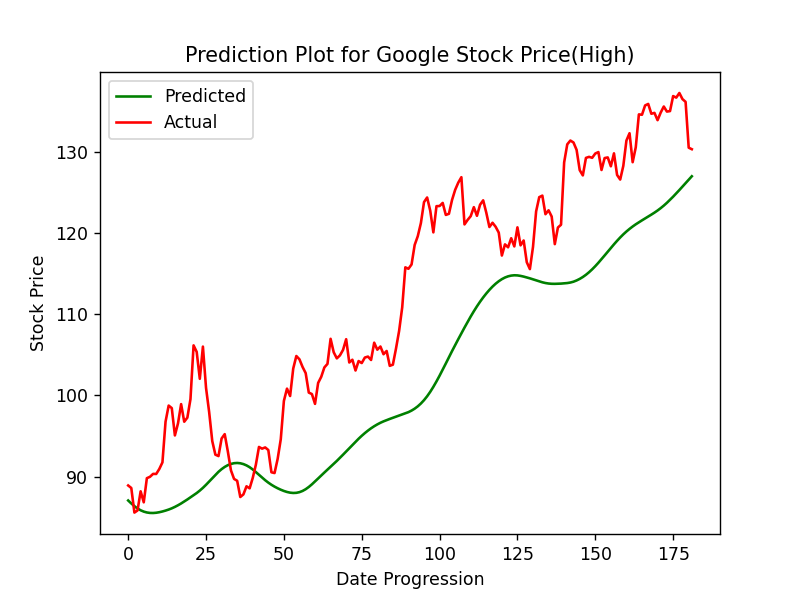

In [25]:
# Prediction Plot

plt.figure()
plt.plot(p, color='green', label='Predicted')
plt.plot(y, color='red', label='Actual')
plt.title('Prediction Plot for Google Stock Price(High)')
plt.xlabel('Date Progression')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('result.png')
plt.show()